In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_path = "./AlzModel.keras"
loaded_model = tf.keras.models.load_model(model_path)

2024-05-06 21:16:40.591063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 21:16:40.597155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 21:16:40.597401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 21:16:40.598941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
SEED = 32  
WIDTH = 224 
HEIGHT = 224
dataPath = './data'
testPath = os.path.join(dataPath, 'val')

In [15]:
def processer(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    predictions = loaded_model.predict(image)
    predicted_category_index = np.argmax(predictions)
    CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

    print("Predicted category index:", CATEGORIES[predicted_category_index])

In [16]:
processer("./data/val/NonDemented/26 (63).jpg")

1/1 [==============================] - 0s 35ms/step
Predicted category index: NonDemented


In [17]:
processer("./data/new/verymildDem97.jpg")

1/1 [==============================] - 0s 41ms/step
Predicted category index: VeryMildDemented


In [22]:
testData = []
for category_id, category in enumerate(CATEGORIES):
    categoryPath = os.path.join(testPath, category)
    for file in os.listdir(categoryPath):
        filePath = os.path.join(categoryPath, file)
        testData.append([filePath, category_id, category])
        
testDataFrame = pd.DataFrame(testData, columns=['file', 'category_id', 'category'])
testDataFrame.shape

(6400, 3)

In [24]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_dataframe(
    dataframe=testDataFrame,
    directory=testPath,
    x_col="file",
    y_col="category",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH)
)

Found 6400 validated image filenames belonging to 4 classes.


In [25]:
loss, accuracy = loaded_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 19s 80ms/step - loss: 0.1669 - accuracy: 0.9373

Test loss: 0.17 
Test Accuracy: 93.73 %


In [27]:
predictions = loaded_model.predict(test_generator)

# Convert predictions to class labels
predictedClasses = np.argmax(predictions, axis=1)
trueClasses = test_generator.classes
classLabels = list(test_generator.class_indices.keys())

# Generate classification report and print
ClassReport = classification_report(trueClasses, predictedClasses, target_names=classLabels, output_dict=True)
GeneralReport = classification_report(trueClasses, predictedClasses, target_names=classLabels)

print(ClassReport)
print(GeneralReport)

200/200 [==============================] - 15s 75ms/step
{'MildDemented': {'precision': 0.9985632183908046, 'recall': 0.7756696428571429, 'f1-score': 0.8731155778894473, 'support': 896.0}, 'ModerateDemented': {'precision': 0.927536231884058, 'recall': 1.0, 'f1-score': 0.9624060150375939, 'support': 64.0}, 'NonDemented': {'precision': 0.9927536231884058, 'recall': 0.941875, 'f1-score': 0.9666452854393842, 'support': 3200.0}, 'VeryMildDemented': {'precision': 0.856483262793382, 'recall': 0.99375, 'f1-score': 0.9200247985120893, 'support': 2240.0}, 'accuracy': 0.93734375, 'macro avg': {'precision': 0.9438340840641626, 'recall': 0.9278236607142857, 'f1-score': 0.9305479192196286, 'support': 6400.0}, 'weighted avg': {'precision': 0.9452201664654399, 'recall': 0.93734375, 'f1-score': 0.9371915632538219, 'support': 6400.0}}
                  precision    recall  f1-score   support

    MildDemented       1.00      0.78      0.87       896
ModerateDemented       0.93      1.00      0.96       

[[ 695    0    1    0]
 [   2   64    3    0]
 [   8    0 3014   14]
 [ 191    0  182 2226]]


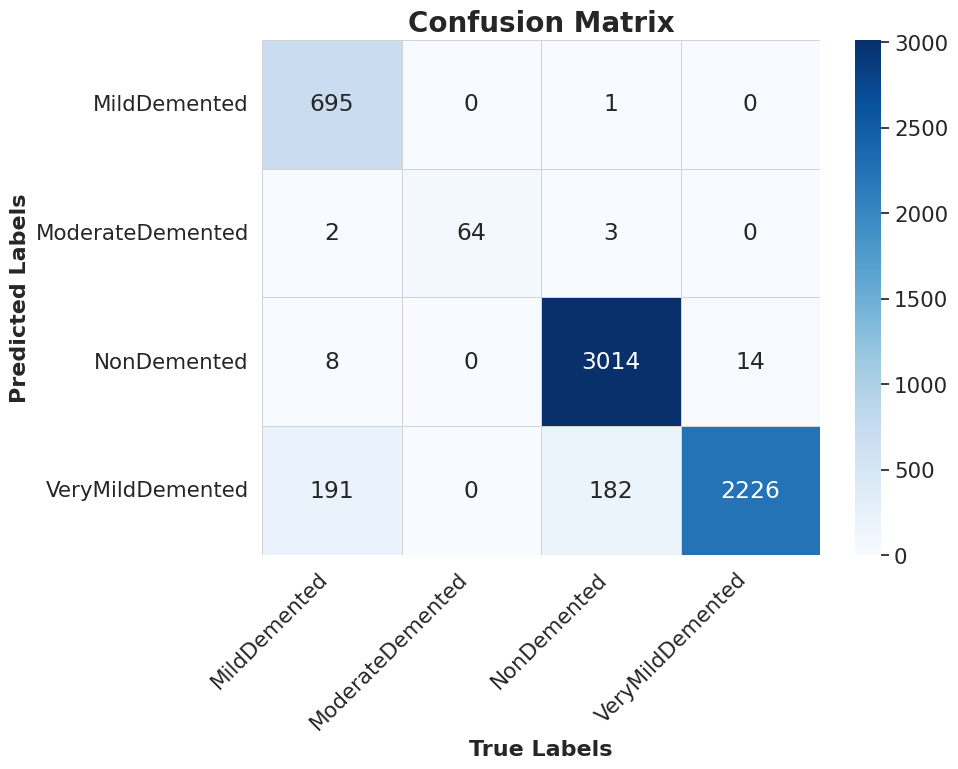

In [33]:
confMatrix = confusion_matrix(predictedClasses, trueClasses)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Adjust font size
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=classLabels, yticklabels=classLabels, linewidths=0.5, linecolor='lightgray')
plt.xlabel('True Labels', fontsize=16, fontweight='bold')
plt.ylabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)   
plt.tight_layout()  
plt.show()